# Imports

In [495]:
!pip install numpy pandas matplotlib plotly scipy scikit-image scikit-learn torch torchvision kagglehub
!pip install nbformat

In [496]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.nn.functional as F
import kagglehub
import os

In [497]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
pmem = True if device == "cuda" else False
print(device)

mps


In [498]:
transform = transforms.Compose([transforms.ToTensor()])
images = torchvision.datasets.ImageFolder("coil-20-proc", transform=transform)
print(images.classes)
train_images = DataLoader(images, batch_size=72, shuffle=True, pin_memory=pmem)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']


In [499]:
def label_string(label_int):
    match label_int:
        case 0:
            return "duck"
        case 1:
            return "block toy"
        case 2:
            return "toy racecar"
        case 3:
            return "waving cat"
        case 4:
            return "anacin box"
        case 5:
            return "toy convertible"
        case 6:
            return "block toy 2"
        case 7:
            return "baby powder"
        case 8:
            return "tylenol"
        case 9:
            return "vaseline"
        case 10:
            return "block toy (semicircle)"
        case 11:
            return "cup"
        case 12:
            return "piggy bank"
        case 13:
            return "valve"
        case 14:
            return "bucket"
        case 15:
            return "conditioner bottle"
        case 16:
            return "pot"
        case 17:
            return "teacup"
        case 18:
            return "toy convertible (lame)"
        case 19:
            return "cream cheese tub"
        case _:
            return "none of the above"

In [500]:
train_images

In [501]:
model = nn.Sequential()
model.add_module(
    'conv1',
    nn.Conv2d(
        in_channels=3,out_channels=32,
        kernel_size=5,padding=2
    )
)
model.add_module('relu1',nn.ReLU())
model.add_module('pool1',nn.MaxPool2d(kernel_size=2))

model.add_module(
    'conv2',
    nn.Conv2d(
        in_channels=32, out_channels=64,
        kernel_size=5,padding=2
    )
)
model.add_module('relu2',nn.ReLU())
model.add_module('pool2',nn.MaxPool2d(kernel_size=2))

model.add_module('flatten',nn.Flatten())

x = torch.ones((4,3,128,128))
dims = model(x).shape

model.add_module('fc1',nn.Linear(dims[1], 1024))
model.add_module('relu3', nn.ReLU())
model.add_module('dropout',nn.Dropout(p=0.5))
model.add_module('fc2',nn.Linear(1024,20))
model.to(device)

Sequential(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=65536, out_features=1024, bias=True)
  (relu3): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=1024, out_features=20, bias=True)
)

In [502]:
num_epochs = 5 

loss_history_train = np.zeros(num_epochs)
accuracy_history_train = np.zeros(num_epochs)
loss_history_valid = np.zeros(num_epochs)
accuracy_history_valid = np.zeros(num_epochs)

In [503]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
torch.manual_seed(540)

noise_std = 0.011

for epoch in range(num_epochs):
    model.train()
    for x_batch, y_batch in train_images:
        # test adding noise:
        noise = torch.randn_like(x_batch)*noise_std
        x_batch = x_batch + noise

        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        pred = model(x_batch)
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        loss_history_train[epoch] += loss.item()*y_batch.size(0)
        accuracy_history_valid[epoch] += is_correct.sum()
    
    model.eval()
    print(epoch)

#torch.save(model.state_dict(), "prebuilts/coil20_{:.3f}.pth".format(noise_std))


0
1
2
3
4


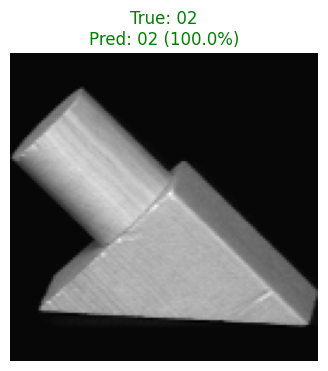

In [505]:
img_tensor, label = images[73]
input_tensor = img_tensor.unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    logits = model(input_tensor)
    probs = F.softmax(logits, dim=1)
    confidence, pred_label = torch.max(probs,1)

    predicted_class = images.classes[pred_label.item()]
    true_class = images.classes[label]
    conf_score = confidence.item()

    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.permute(1,2,0))
    title_color = 'green' if predicted_class == true_class else 'red'
    plt.title(f"True: {true_class}\nPred: {predicted_class} ({conf_score:.1%})", color=title_color)
    plt.axis('off')
    plt.show()

In [506]:
count_correct = 0
incorrect = []
for i in range(1440):
    img_tensor, label = images[i]
    input_tensor = img_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = F.softmax(logits, dim=1)
        confidence, pred_label = torch.max(probs,1)

        predicted_class = images.classes[pred_label.item()]
        true_class = images.classes[label]
        conf_score = confidence.item()
        if predicted_class == true_class:
            count_correct += 1
        else:
            incorrect.append(i)


In [507]:
def display_image_tensor(img_tensor):
    plt.figure(figsize=(4,4))
    plt.imshow(img_tensor.permute(1,2,0))
    plt.axis('off')
    plt.show()
    

In [508]:
count_correct

1440

In [509]:
count_correct/1440

1.0

In [523]:
def attack(image_index, delta, n):
    # Attack
    #perturbed_image_disp = perturbed_image.cpu().detach()
    #display_image_tensor(perturbed_image_disp)
    image_tensor, label = images[image_index]
    start_image = image_tensor.unsqueeze(0).to(device)
    label = torch.Tensor([label]).to(device)
    start_image.requires_grad = True
    for i in range(n):

        start_image.requires_grad = True

        output = model(start_image)
        init_pred = output.max(1, keepdim=True)[1]

        loss = F.nll_loss(output, label.long())
        model.zero_grad()
        loss.backward()

        image_grad = start_image.grad.data
        #grad_sign = torch.sign(image_grad)
        perturbed_image = start_image + delta*image_grad
        #perturbed_image = start_image + delta*grad_sign
        perturbed_image = torch.clamp(perturbed_image,0,1)

        output_pert = model(perturbed_image)

        pert_pred = output_pert.max(1,keepdim=True)[1]
        probs_init = F.softmax(output, dim=1)
        probs_pert = F.softmax(output_pert, dim=1)

        confidence_init, pred_label_init = torch.max(probs_init,1)
        conf_init_float = float(confidence_init.detach())
        pred_init_int = int(pred_label_init.detach())

        confidence_pert, pred_label_pert = torch.max(probs_pert,1)
        conf_pert_float = float(confidence_pert.detach())
        pred_pert_int = int(pred_label_pert.detach())
        #print("init_pred: {}, with confidence: {:f}".format(label_string(pred_init_int), conf_init_float))
        #print("pred: {}, with confidence: {:f}".format(label_string(pred_pert_int), conf_pert_float))
        if init_pred != pert_pred:
            break
        start_image = perturbed_image.detach()

    return_image = start_image.squeeze(0).cpu().detach()
    diff_image = torch.abs(return_image - image_tensor)

    return return_image, diff_image

In [511]:
def attack_sign(image_index, eps, n):
    # Attack
    #perturbed_image_disp = perturbed_image.cpu().detach()
    #display_image_tensor(perturbed_image_disp)
    image_tensor, label = images[image_index]
    start_image = image_tensor.unsqueeze(0).to(device)
    label = torch.Tensor([label]).to(device)
    start_image.requires_grad = True
    for i in range(n):

        start_image.requires_grad = True

        output = model(start_image)
        init_pred = output.max(1, keepdim=True)[1]

        loss = F.nll_loss(output, label.long())
        model.zero_grad()
        loss.backward()

        image_grad = start_image.grad.data
        grad_sign = torch.sign(image_grad)
        #perturbed_image = start_image + delta*image_grad
        perturbed_image = start_image + eps*grad_sign
        perturbed_image = torch.clamp(perturbed_image,0,1)

        output_pert = model(perturbed_image)

        pert_pred = output_pert.max(1,keepdim=True)[1]
        probs_init = F.softmax(output, dim=1)
        probs_pert = F.softmax(output_pert, dim=1)

        confidence_init, pred_label_init = torch.max(probs_init,1)
        conf_init_float = float(confidence_init.detach())
        pred_init_int = int(pred_label_init.detach())

        confidence_pert, pred_label_pert = torch.max(probs_pert,1)
        conf_pert_float = float(confidence_pert.detach())
        pred_pert_int = int(pred_label_pert.detach())
        #print("init_pred: {}, with confidence: {:f}".format(label_string(pred_init_int), conf_init_float))
        print("pred: {}, with confidence: {:f}".format(label_string(pred_pert_int), conf_pert_float))
        if init_pred != pert_pred:
            break
        start_image = perturbed_image.detach()

    return_image = start_image.squeeze(0).cpu().detach()
    diff_image = torch.abs(return_image - image_tensor)

    return return_image, diff_image


pred: duck, with confidence: 0.999998
pred: duck, with confidence: 0.999994
pred: duck, with confidence: 0.999984
pred: duck, with confidence: 0.999954
pred: duck, with confidence: 0.999863
pred: duck, with confidence: 0.999565
pred: duck, with confidence: 0.998406
pred: duck, with confidence: 0.993259
pred: duck, with confidence: 0.967983
pred: duck, with confidence: 0.845400
pred: duck, with confidence: 0.474287
pred: toy convertible (lame), with confidence: 0.689960
tensor(9.9466)


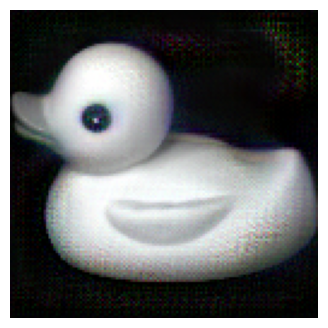

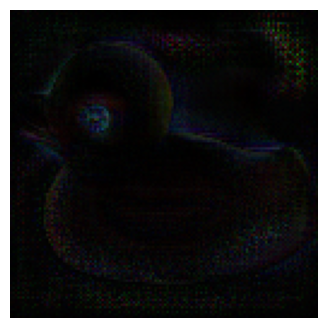

In [512]:
image_attack, diff = attack(0, 1,200)
print(torch.norm(diff))
display_image_tensor(image_attack)
display_image_tensor(diff)

pred: duck, with confidence: 0.999997
pred: duck, with confidence: 0.999985
pred: duck, with confidence: 0.999935
pred: duck, with confidence: 0.999672
pred: duck, with confidence: 0.998272
pred: duck, with confidence: 0.989851
pred: duck, with confidence: 0.937819
pred: duck, with confidence: 0.679005
pred: block toy, with confidence: 0.358037
tensor(11.8634)


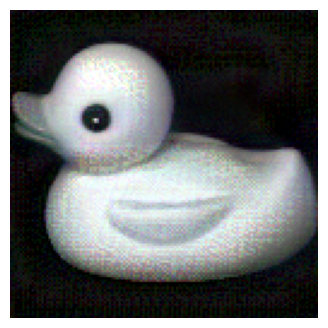

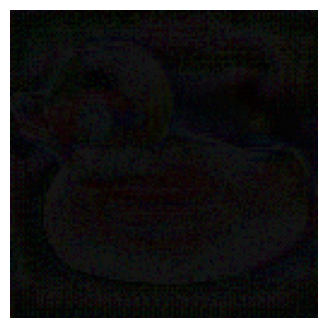

In [513]:
image_attack_sign, diff_sign = attack_sign(0,0.01,200)
print(torch.norm(diff_sign))
display_image_tensor(image_attack_sign)
display_image_tensor(diff_sign)

In [514]:
ducks = torchvision.datasets.ImageFolder("ducks", transform=transform)

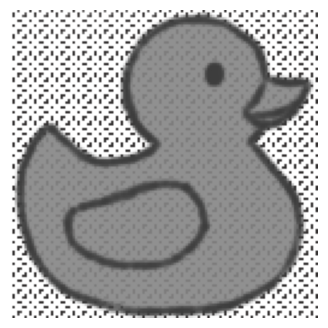

In [515]:
my_duck,_ = ducks[5]
display_image_tensor(my_duck)
my_duck = my_duck.unsqueeze(0).to(device)
my_output = model(my_duck)
probs = F.softmax(my_output, dim=1)
confidence, pred_label = torch.max(probs,1)

In [516]:
float(confidence.detach())

0.9999904632568359

In [517]:
pred_label

tensor([8], device='mps:0')

In [ ]:
results = []
for i in range(101):
    results_i = []
    model_path = "prebuilts/coil20_0.{:03d}.pth".format(i)
    print(model_path)
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    for j in range(1440):
        image,diff = attack(j,1,200)
        #print(torch.norm(diff))
        results_i.append(torch.norm(diff))
    results.append(results_i)
    torch.mps.empty_cache()

prebuilts/coil20_0.000.pth
tensor(9.6142)
tensor(9.2746)
tensor(9.2049)
tensor(9.6379)
tensor(8.6858)
prebuilts/coil20_0.001.pth
tensor(4.6461)
tensor(4.5753)
tensor(7.8448)
tensor(7.4151)
tensor(5.6287)
prebuilts/coil20_0.002.pth
tensor(12.1661)
tensor(11.8710)
tensor(11.1242)
tensor(13.6506)
tensor(13.4658)
prebuilts/coil20_0.003.pth
tensor(10.7508)
tensor(10.3937)
tensor(11.2560)
tensor(12.1952)
tensor(12.0257)
prebuilts/coil20_0.004.pth
tensor(10.1181)
tensor(9.9608)
tensor(11.5931)
tensor(12.5740)
tensor(10.8317)


In [538]:
results

[[tensor(9.6142),
  tensor(9.2746),
  tensor(9.2049),
  tensor(9.6379),
  tensor(8.6858)],
 [tensor(4.6461),
  tensor(4.5753),
  tensor(7.8448),
  tensor(7.4151),
  tensor(5.6287)],
 [tensor(12.1661),
  tensor(11.8710),
  tensor(11.1242),
  tensor(13.6506),
  tensor(13.4658)],
 [tensor(10.7508),
  tensor(10.3937),
  tensor(11.2560),
  tensor(12.1952),
  tensor(12.0257)],
 [tensor(10.1181),
  tensor(9.9608),
  tensor(11.5931),
  tensor(12.5740),
  tensor(10.8317)]]